In [1]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import dask
import scipy
import scipy.io as sio
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
from statistics import mode
from matplotlib import transforms
import itertools
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
bm = Basemap()
import netCDF4

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [2]:
fz = 15
lw = 3
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement
LWC = 2.0

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [3]:
#Good_July.nc
path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Preprocessed_Data/One_Month_July/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/Good_July.nc'
test_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Models/CAM_July.nc'
CAM_ds = xr.open_dataset(path_to_file)

print('files imported')

files imported


In [4]:
heat_SPCAM5 = real_ds.targets[:, 19].values

heat_DNN = test_ds.Prediction[:, 19].values

heat_CAM = CAM_ds.PTTEND.values

moisture_SPCAM5 = real_ds.targets[:, 49].values

moisture_DNN = test_ds.Prediction[:, 49].values

moisture_CAM = CAM_ds.PTEQ.values

precip_SPCAM5 = real_ds.targets[:, -1].values

precip_DNN = test_ds.Prediction[:, -1].values

precip_CAM = CAM_ds.PRECT.values

FLNT_SPCAM5 = real_ds.targets[:, -3].values

FLNT_DNN = test_ds.Prediction[:, -3].values

FLNT_CAM = CAM_ds.FLNT.values


times = real_ds.time.values

lats = real_ds.lat.values

lons = real_ds.lon.values

In [5]:
x = 144
y = 96
z = 30
t = int(len(heat_SPCAM5)/(x*y))
print(t)

Target_Heat = np.zeros(shape=(x, y, t))
NN_Heat = np.zeros(shape=(x, y, t))

Target_Moisture = np.zeros(shape=(x, y, t))
NN_Moisture = np.zeros(shape=(x, y, t))

Target_Precip = np.zeros(shape=(x, y, t))
NN_Precip = np.zeros(shape=(x, y, t))

Target_OLR = np.zeros(shape=(x, y, t))
NN_OLR = np.zeros(shape=(x, y, t))

count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = heat_SPCAM5[count]
            B = heat_DNN[count]
            C = moisture_SPCAM5[count]
            D = moisture_DNN[count]
            E = precip_SPCAM5[count]
            F = precip_DNN[count]
            G = FLNT_SPCAM5[count]
            H = FLNT_DNN[count]
            Target_Heat[k, j, i] = A
            NN_Heat[k, j, i] = B
            Target_Moisture[k, j, i] = C
            NN_Moisture[k, j, i] = D
            Target_Precip[k, j, i] = E
            NN_Precip[k, j, i] = F
            Target_OLR[k, j, i] = G
            NN_OLR[k, j, i] = H
            count = count + 1


2975


In [6]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
L = 2256000.0
#print(plev)
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
#print(hyai.shape)
#print(hyai)
cp = 1004.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
#convert from k/s to w/m^2


pressure_weighted_Target_Heat = Target_Heat*dp[19]*cp/g
pressure_weighted_NN_Heat = NN_Heat*dp[19]*cp/g
pressure_weighted_CAM_Heat = np.squeeze(heat_CAM[:,19,:,:])*dp[19]*cp/g

pressure_weighted_Target_Moisture = Target_Moisture*dp[19]*L/g
pressure_weighted_NN_Moisture = NN_Moisture*dp[19]*L/g
pressure_weighted_CAM_Moisture = np.squeeze(moisture_CAM[:,19,:,:])*dp[19]*L/g

weighted_Target_Precip = Target_Precip*86400000.
weighted_NN_Precip = NN_Precip*86400000.
weighted_CAM_Precip = precip_CAM*86400000.

In [7]:
def Heating_Moistening_Animation(heat_truth, heat_pred, moisture_truth, moisture_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,2,figsize=(10,7.5),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    for i in range(timesteps):
        # (a) Convective Moistening
        im_a = ax[0,0].imshow(np.squeeze(moisture_truth[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        #im = ax[0,0].imshow(coor.TS[it,:,:].values,cmap='bwr',transform=ccrs.PlateCarree())
        ax[0,0].set_title('Cloud-Resolving Model')
        ax[0,0].set_global()
        ax[0,0].add_feature(cfeature.COASTLINE)
        if i == 0:
            cb = fig.colorbar(im_a, ax=ax[0,0], pad=0.01, extend='both', orientation='horizontal'); 
            cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')

        # (b) Convective Heating
        im_b = ax[0,1].imshow(np.squeeze(heat_truth[:,:,i]).T, cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[0,1].set_title('Cloud-Resolving Model')
        ax[0,1].add_feature(cfeature.COASTLINE)
        if i == 0:
            cb = fig.colorbar(im_b, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
            cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')

        # (a) Convective Moistening
        im_c = ax[1,0].imshow(np.squeeze(moisture_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[1,0].set_title('Neural Network')
        ax[1,0].add_feature(cfeature.COASTLINE)
        #cb = fig.colorbar(im, ax=ax[1,0], pad=0.01, extend='both', orientation='horizontal'); 
        #cb.set_label('$\mathrm{PRED\ 600hPa\ Convective\ Moistening\ (W/m^{2})}$')

        # (b) Convective Heating
        im_d = ax[1,1].imshow(np.squeeze(heat_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[1,1].set_title('Neural Network')
        ax[1,1].add_feature(cfeature.COASTLINE)
        
        feat_list.append([im_a, im_b, im_c, im_d])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 100, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/Video_For_Tom.mp4')
    plt.show()
    
#Heating_Moistening_Animation(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, 100, -150, 150)    

In [8]:
def Mikes_Animation(heat_truth, heat_pred, moisture_truth, moisture_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,2,figsize=(10,7.5),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    for i in range(timesteps):
        if i %2 == 0:
            im_a = ax[0,0].imshow(np.squeeze(moisture_truth[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,0].set_title('Cloud-Resolving Model')
            ax[0,0].set_global()
            ax[0,0].add_feature(cfeature.COASTLINE)
            if i == 0:
                cb = fig.colorbar(im_a, ax=ax[0,0], pad=0.01, extend='both', orientation='horizontal'); 
                cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')

            im_b = ax[0,1].imshow(np.squeeze(heat_truth[:,:,i]).T, cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,1].set_title('Cloud-Resolving Model')
            ax[0,1].add_feature(cfeature.COASTLINE)
            if i == 0:
                cb = fig.colorbar(im_b, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
                cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')

            im_c = ax[1,0].imshow(np.squeeze(moisture_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1,0].set_title('Neural Network')
            ax[1,0].add_feature(cfeature.COASTLINE)

            im_d = ax[1,1].imshow(np.squeeze(heat_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1,1].set_title('Neural Network')
            ax[1,1].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b, im_c, im_d])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 30, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/14_days_heating_moistening.mp4')
    plt.show()
    
#Mikes_Animation(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, 1342, -150, 150) 

In [9]:
print(pressure_weighted_CAM_Moisture.shape)

(2976, 96, 144)


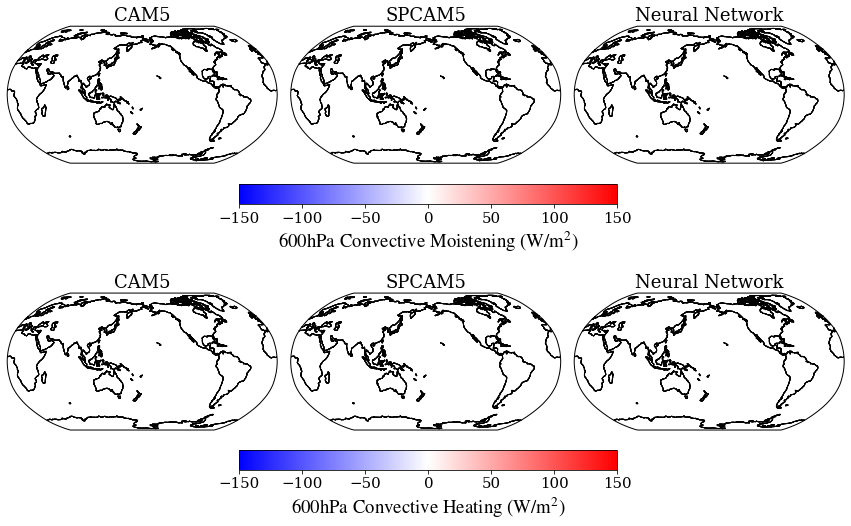

In [11]:
def Heating_Moistening_14_Days_Animation(heat_truth, heat_pred, heat_cam, moisture_truth, moisture_pred, moist_cam, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,3,figsize=(15,9),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    for i in range(timesteps):
        if i %2 == 0:
            im_a = ax[0,0].imshow(np.squeeze(moist_cam[i,:,:]),cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,0].set_title('CAM5')
            ax[0,0].set_global()
            ax[0,0].add_feature(cfeature.COASTLINE)
            if i == 0:
                #cb = fig.colorbar(im_a, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
                #cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')
                cax = fig.add_axes([0.34, 0.54, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$', fontsize=fz*1.25)

            im_b = ax[1,0].imshow(np.squeeze(heat_cam[i,:,:]), cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1,0].set_title('CAM5')
            ax[1,0].add_feature(cfeature.COASTLINE)
            if i == 0:
                #cb = fig.colorbar(im_b, ax=ax[1,1], pad=0.01, extend='both', orientation='horizontal'); 
                #cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')
                cax_2 = fig.add_axes([0.34, 0.13, 0.35, 0.03])
                cb_2 = fig.colorbar(im_b, orientation='horizontal', cax=cax_2)
                cb_2.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$', fontsize=fz*1.25)

            im_c = ax[0,1].imshow(np.squeeze(moisture_truth[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,1].set_title('SPCAM5')
            ax[0,1].add_feature(cfeature.COASTLINE)

            im_d = ax[1,1].imshow(np.squeeze(heat_truth[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1,1].set_title('SPCAM5')
            ax[1,1].add_feature(cfeature.COASTLINE)
            
            im_e = ax[0,2].imshow(np.squeeze(moisture_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,2].set_title('Neural Network')
            ax[0,2].add_feature(cfeature.COASTLINE)

            im_f = ax[1,2].imshow(np.squeeze(heat_pred[:,:,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1,2].set_title('Neural Network')
            ax[1,2].add_feature(cfeature.COASTLINE)
            plt.subplots_adjust(wspace=0.05)
            feat_list.append([im_a, im_b, im_c, im_d, im_e, im_f])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 30, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/Paper_14_days_heating_moistening.mp4')
    plt.show()
    
Heating_Moistening_14_Days_Animation(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_CAM_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, pressure_weighted_CAM_Moisture, 1342, -150, 150)
#Heating_Moistening_14_Days_Animation(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_CAM_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, pressure_weighted_CAM_Moisture, 10, -150, 150) 

In [35]:
lat = lats[::144]
lon = lons[:144]
trop_lat = lat[29:67]
new_lats, new_lons = np.meshgrid(trop_lat, lon)

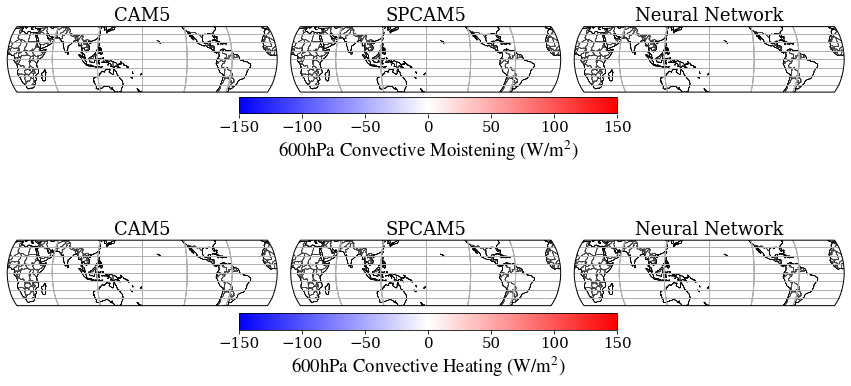

In [44]:
def Heating_Moistening_14_Days_35S_35N_Animation(heat_truth, heat_pred, heat_cam, moisture_truth, moisture_pred, moist_cam, timesteps, vmin, vmax, y_vals, x_vals):
    fig,ax = plt.subplots(2,3,figsize=(15,7.5),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    for i in range(timesteps):
        if i %2 == 0:
            ax[0,0].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[0,0].gridlines()
            ax[0,0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[0,1].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[0,1].gridlines()
            ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[1,0].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[1,0].gridlines()
            ax[1,0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[1,1].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[1,1].gridlines()
            ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[0,2].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[0,2].gridlines()
            ax[0,2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[1,2].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[1,2].gridlines()
            ax[1,2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            
            im_a = ax[0,0].pcolormesh(x_vals, y_vals, np.squeeze(moist_cam[i,29:67,:]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0,0].set_title('CAM5')
            ax[1,0].set_title('CAM5')
            ax[0,1].set_title('SPCAM5')
            ax[1,1].set_title('SPCAM5')
            ax[0,2].set_title('Neural Network')
            ax[1,2].set_title('Neural Network')
            if i == 0:
                #cb = fig.colorbar(im_a, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
                #cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')
                cax = fig.add_axes([0.34, 0.60, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$', fontsize=fz*1.25)

            im_b = ax[1,0].pcolormesh(x_vals, y_vals, np.squeeze(heat_cam[i,29:67,:]).T, cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            if i == 0:
                #cb = fig.colorbar(im_b, ax=ax[1,1], pad=0.01, extend='both', orientation='horizontal'); 
                #cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')
                cax_2 = fig.add_axes([0.34, 0.20, 0.35, 0.03])
                cb_2 = fig.colorbar(im_b, orientation='horizontal', cax=cax_2)
                cb_2.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$', fontsize=fz*1.25)

            im_c = ax[0,1].pcolormesh(x_vals.T, y_vals.T, np.squeeze(moisture_truth[:,29:67,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())

            im_d = ax[1,1].pcolormesh(x_vals.T, y_vals.T, np.squeeze(heat_truth[:,29:67,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            
            im_e = ax[0,2].pcolormesh(x_vals.T, y_vals.T, np.squeeze(moisture_pred[:,29:67,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())

            im_f = ax[1,2].pcolormesh(x_vals.T, y_vals.T, np.squeeze(heat_pred[:,29:67,i]).T,cmap='bwr', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            plt.subplots_adjust(wspace=0.05, hspace=0.10)
            feat_list.append([im_a, im_b, im_c, im_d, im_e, im_f])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 30, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/35S_35N_Paper_14_days_heating_moistening.mp4')
    plt.show()
    
#Heating_Moistening_14_Days_35S_35N_Animation(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_CAM_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, pressure_weighted_CAM_Moisture, 1342, -150, 150, new_lats, new_lons)
#Heating_Moistening_14_Days_35S_35N_Animation(pressure_weighted_Target_Heat, pressure_weighted_NN_Heat, pressure_weighted_CAM_Heat, pressure_weighted_Target_Moisture, pressure_weighted_NN_Moisture, pressure_weighted_CAM_Moisture, 10, -150, 150, new_lats, new_lons)

In [9]:
def Precip_1_Day_Animation(precip_truth, precip_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,1,figsize=(5,7.5),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    for i in range(timesteps):
        im_a = ax[0].imshow(np.squeeze(precip_truth[:,:,i]).T,cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[0].set_title('Cloud-Resolving Model')
        ax[0].set_global()
        ax[0].add_feature(cfeature.COASTLINE)
        if i == 0:
            cb = fig.colorbar(im_a, ax=ax[0], pad=0.01, extend='both', orientation='horizontal'); 
            cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$')

        im_b = ax[1].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
        ax[1].set_title('Neural Network')
        ax[1].add_feature(cfeature.COASTLINE)
        
        feat_list.append([im_a, im_b])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 100, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/1_Day_Precip.mp4')
    plt.show()
    
#Precip_1_Day_Animation(weighted_Target_Precip, weighted_NN_Precip, 100, 0, 50)    

In [10]:
def Precip_14_Days_Animation(precip_truth, precip_pred, timesteps, vmin, vmax):
    fig,ax = plt.subplots(2,1,figsize=(5,7.5),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    for i in range(timesteps):
        if i%2==0:
            im_a = ax[0].imshow(np.squeeze(precip_truth[:,:,i]).T,cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('Cloud-Resolving Model')
            ax[0].set_global()
            ax[0].add_feature(cfeature.COASTLINE)
            if i == 0:
                cb = fig.colorbar(im_a, ax=ax[0], pad=0.01, extend='both', orientation='horizontal'); 
                cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$')

            im_b = ax[1].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('Neural Network')
            ax[1].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b])
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/14_Day_Precip.mp4')
    plt.show()
    
#Precip_14_Days_Animation(weighted_Target_Precip, weighted_NN_Precip, 1342, 0, 50) 
#Precip_14_Days_Animation(weighted_Target_Precip, weighted_NN_Precip, 10, 0, 50)

In [11]:
def Improved_Precip_14_Days_Animation(precip_truth, precip_pred, timesteps, vmin, vmax):
    #fig,ax = plt.subplots(2,1,figsize=(5,7.5),subplot_kw=dict(projection=ccrs.Robinson()))
    fig,ax = plt.subplots(1,2,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    for i in range(timesteps):
        if i%2==0:
            im_a = ax[0].imshow(np.squeeze(precip_truth[:,:,i]).T,cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('Cloud-Resolving Model')
            ax[0].set_global()
            ax[0].add_feature(cfeature.COASTLINE)
            if i == 0:
                #cbar_ax = fig.add_axes([0.82, 0.12, 0.05, 0.76])
                #cb = fig.colorbar(im_a, ax=cbar_ax, pad=0.01, extend='both'); 
                #cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$')
                cax = fig.add_axes([0.34, .17, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$', fontsize=fz*1.25)

            im_b = ax[1].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap='Greens', vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('Neural Network')
            ax[1].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b])
            plt.subplots_adjust(wspace=0.02)
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/Revised_14_Day_Precip.mp4')
    plt.show()
    
#Improved_Precip_14_Days_Animation(weighted_Target_Precip, weighted_NN_Precip, 1342, 0, 50) 
#Improved_Precip_14_Days_Animation(weighted_Target_Precip, weighted_NN_Precip, 10, 0, 50)

In [12]:
def Improved_3_Panel_Precip_14_Days_Animation(precip_truth, precip_pred, cam5_precip, timesteps, vmin, vmax):
    #fig,ax = plt.subplots(1,3,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson()))
    fig,ax = plt.subplots(1,3,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    cmap = 'Greens'
    for i in range(timesteps):
        if i%2==0:
            im_a = ax[0].imshow(np.squeeze(cam5_precip[i,:,:]),cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('CAM5')
            ax[0].set_global()
            ax[0].add_feature(cfeature.COASTLINE)
            if i == 0:
                #cax = fig.add_axes([0.34, .17, 0.35, 0.03])
                cax = fig.add_axes([0.34, .25, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$', fontsize=fz*1.25)

            im_b = ax[1].imshow(np.squeeze(precip_truth[:,:,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('SPCAM5')
            ax[1].add_feature(cfeature.COASTLINE)
            
            im_c = ax[2].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[2].set_title('Neural Network')
            ax[2].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b, im_c])
            plt.subplots_adjust(wspace=0.02)
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/3_Panel_14_Day_Precip.mp4')
    plt.show()
    
#Improved_3_Panel_Precip_14_Days_Animation(weighted_Target_Precip, weighted_NN_Precip, weighted_CAM_Precip, 1342, 0, 50) 
#Improved_3_Panel_Precip_14_Days_Animation(weighted_Target_Precip, weighted_NN_Precip, weighted_CAM_Precip, 10, 0, 50)

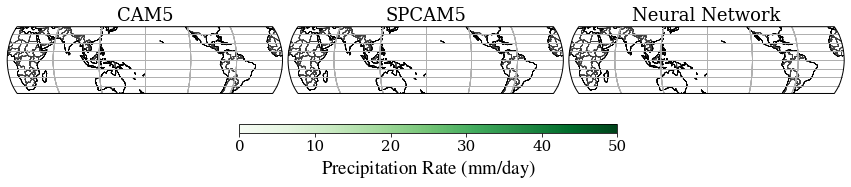

In [56]:
def Improved_3_Panel_Precip_14_Days_35S_35N_Animation(precip_truth, precip_pred, cam5_olr, timesteps, vmin, vmax, y_vals, x_vals):
    #fig,ax = plt.subplots(1,3,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson()))
    fig,ax = plt.subplots(1,3,figsize=(15,4),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    cmap = "Greens"
    for i in range(timesteps):
        if (i)%2==0:
            im_a = ax[0].pcolormesh(x_vals, y_vals, np.squeeze(cam5_olr[i,29:67,:]).T,cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('CAM5')
            ax[0].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[0].gridlines()
            ax[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[1].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[1].gridlines()
            ax[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[2].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[2].gridlines()
            ax[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            if i == 0:
                cax = fig.add_axes([0.34, .25, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{Precipitation\ Rate\ (mm/day)}$', fontsize=fz*1.25)

            im_b = ax[1].pcolormesh(x_vals.T, y_vals.T, np.squeeze(precip_truth[:,29:67,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('SPCAM5')
            #ax[1].add_feature(cfeature.COASTLINE)
            
            im_c = ax[2].pcolormesh(x_vals.T, y_vals.T, np.squeeze(precip_pred[:,29:67,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[2].set_title('Neural Network')
            #ax[2].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b, im_c])
            plt.subplots_adjust(wspace=0.02)
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/35S_35N_3_Panel_14_Day_Precip.mp4')
    plt.show()
    
#Improved_3_Panel_Precip_14_Days_35S_35N_Animation(weighted_Target_Precip, weighted_NN_Precip, weighted_CAM_Precip, 1342, 0, 50, new_lats, new_lons) 
#Improved_3_Panel_Precip_14_Days_35S_35N_Animation(weighted_Target_Precip, weighted_NN_Precip, weighted_CAM_Precip, 20, 0, 50, new_lats, new_lons)

In [45]:
log_weighted_Target_Precip = np.log10(weighted_Target_Precip)
log_weighted_NN_Precip = np.log10(weighted_NN_Precip)
log_weighted_CAM_Precip = np.log10(weighted_CAM_Precip)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


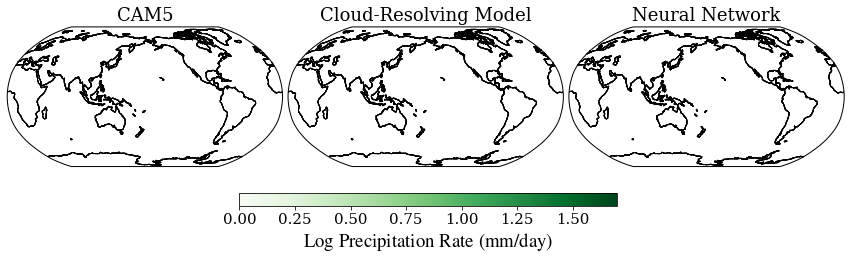

In [53]:
def Improved_3_Panel_Log_Precip_14_Days_Animation(precip_truth, precip_pred, cam5_olr, timesteps, vmin, vmax):
    fig,ax = plt.subplots(1,3,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    cmap="Greens"
    for i in range(timesteps):
        if i%2==0:
            
            im_a = ax[0].imshow(np.squeeze(cam5_olr[i,:,:]),cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('CAM5')
            ax[0].set_global()
            ax[0].add_feature(cfeature.COASTLINE)
            
            im_b = ax[1].imshow(np.squeeze(precip_truth[:,:,i]).T,cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('Cloud-Resolving Model')
            ax[1].set_global()
            ax[1].add_feature(cfeature.COASTLINE)
            if i == 0:
                cax = fig.add_axes([0.34, .25, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{Log\ Precipitation\ Rate\ (mm/day)}$', fontsize=fz*1.25)

            im_c = ax[2].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[2].set_title('Neural Network')
            ax[2].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b, im_c])
            plt.subplots_adjust(wspace=0.02)
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/Paper_14_Day_Log10_Precip.mp4')
    plt.show()
    
#Improved_3_Panel_Log_Precip_14_Days_Animation(log_weighted_Target_Precip, log_weighted_NN_Precip, log_weighted_CAM_Precip, 1342, 0, 1.7) 
#Improved_3_Panel_Log_Precip_14_Days_Animation(log_weighted_Target_Precip, log_weighted_NN_Precip, log_weighted_CAM_Precip, 10, 0, 1.7) 

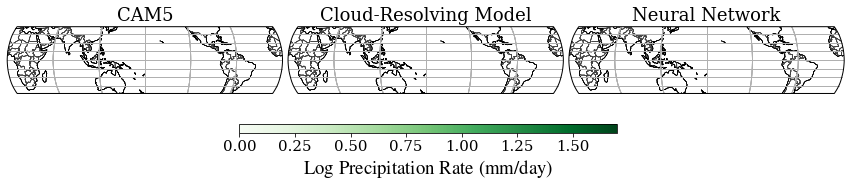

In [57]:
def Improved_3_Panel_Log_Precip_14_Days_35S_35N_Animation(precip_truth, precip_pred, cam5_olr, timesteps, vmin, vmax, y_vals, x_vals):
    fig,ax = plt.subplots(1,3,figsize=(15,4),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    cmap="Greens"
    for i in range(timesteps):
        if i%2==0:
            
            im_a = ax[0].pcolormesh(x_vals, y_vals, np.squeeze(cam5_olr[i,29:67,:]).T,cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('CAM5')
            ax[0].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[0].gridlines()
            ax[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[1].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[1].gridlines()
            ax[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[2].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[2].gridlines()
            ax[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            im_b = ax[1].pcolormesh(x_vals.T, y_vals.T, np.squeeze(precip_truth[:,29:67,i]).T,cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('Cloud-Resolving Model')
            if i == 0:
                cax = fig.add_axes([0.34, .25, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{Log\ Precipitation\ Rate\ (mm/day)}$', fontsize=fz*1.25)

            im_c = ax[2].pcolormesh(x_vals.T, y_vals.T, np.squeeze(precip_pred[:,29:67,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[2].set_title('Neural Network')
        
            feat_list.append([im_a, im_b, im_c])
            plt.subplots_adjust(wspace=0.02)
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/35S_35N_Paper_14_Day_Log10_Precip.mp4')
    plt.show()
    
#Improved_3_Panel_Log_Precip_14_Days_35S_35N_Animation(log_weighted_Target_Precip, log_weighted_NN_Precip, log_weighted_CAM_Precip, 1342, 0, 1.7, new_lats, new_lons) 
#Improved_3_Panel_Log_Precip_14_Days_35S_35N_Animation(log_weighted_Target_Precip, log_weighted_NN_Precip, log_weighted_CAM_Precip, 10, 0, 1.7, new_lats, new_lons)

In [15]:
def Improved_3_Panel_OLR_14_Days_Animation(precip_truth, precip_pred, cam5_olr, timesteps, vmin, vmax):
    #fig,ax = plt.subplots(1,3,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson()))
    fig,ax = plt.subplots(1,3,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    cmap = "bwr"
    for i in range(timesteps):
        if (i+1)%2==0:
            im_a = ax[0].imshow(np.squeeze(cam5_olr[i,:,:]),cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('CAM5')
            ax[0].set_global()
            ax[0].add_feature(cfeature.COASTLINE)
            if i == 1:
                cax = fig.add_axes([0.34, .25, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{TOA\ Radiation\ (w/m^2)}$', fontsize=fz*1.25)

            im_b = ax[1].imshow(np.squeeze(precip_truth[:,:,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('SPCAM5')
            ax[1].add_feature(cfeature.COASTLINE)
            
            im_c = ax[2].imshow(np.squeeze(precip_pred[:,:,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[2].set_title('Neural Network')
            ax[2].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b, im_c])
            plt.subplots_adjust(wspace=0.02)
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/3_Panel_14_Day_TOA_Radiation.mp4')
    plt.show()
    
#Improved_3_Panel_OLR_14_Days_Animation(Target_OLR, NN_OLR, FLNT_CAM, 1343, 0, 400) 
#Improved_3_Panel_OLR_14_Days_Animation(Target_OLR, NN_OLR, FLNT_CAM, 10, 0, 400)

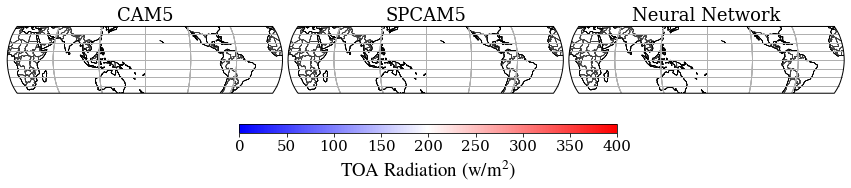

In [53]:
def Improved_3_Panel_OLR_14_Days_35S_35N_Animation(precip_truth, precip_pred, cam5_olr, timesteps, vmin, vmax, y_vals, x_vals):
    #fig,ax = plt.subplots(1,3,figsize=(15,6),subplot_kw=dict(projection=ccrs.Robinson()))
    fig,ax = plt.subplots(1,3,figsize=(15,4),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    feat_list = []
    cmap = "bwr"
    for i in range(timesteps):
        if (i+1)%2==0:
            im_a = ax[0].pcolormesh(x_vals, y_vals, np.squeeze(cam5_olr[i,29:67,:]).T,cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[0].set_title('CAM5')
            ax[0].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[0].gridlines()
            ax[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[1].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[1].gridlines()
            ax[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            ax[2].coastlines(linewidth=0.5,edgecolor='0.25')
            ax[2].gridlines()
            ax[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
            
            if i == 1:
                cax = fig.add_axes([0.34, .25, 0.35, 0.03])
                cb = fig.colorbar(im_a, orientation='horizontal', cax=cax)
                cb.set_label('$\mathrm{TOA\ Radiation\ (w/m^2)}$', fontsize=fz*1.25)

            im_b = ax[1].pcolormesh(x_vals.T, y_vals.T, np.squeeze(precip_truth[:,29:67,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[1].set_title('SPCAM5')
            #ax[1].add_feature(cfeature.COASTLINE)
            
            im_c = ax[2].pcolormesh(x_vals.T, y_vals.T, np.squeeze(precip_pred[:,29:67,i]).T, cmap=cmap, vmin = vmin, vmax=vmax, animated=True, transform=ccrs.PlateCarree())
            ax[2].set_title('Neural Network')
            #ax[2].add_feature(cfeature.COASTLINE)
        
            feat_list.append([im_a, im_b, im_c])
            plt.subplots_adjust(wspace=0.02)
    
    ani = animation.ArtistAnimation(fig, feat_list, interval = 50, blit = False, repeat = True)
    ani.save('/fast/gmooers/Figures/35S_35N_3_Panel_14_Day_TOA_Radiation.mp4')
    plt.show()
    
#Improved_3_Panel_OLR_14_Days_35S_35N_Animation(Target_OLR, NN_OLR, FLNT_CAM, 1343, 0, 400, new_lats, new_lons) 
#Improved_3_Panel_OLR_14_Days_35S_35N_Animation(Target_OLR, NN_OLR, FLNT_CAM, 12, 0, 400, new_lats, new_lons)

In [17]:
print("made it here")

made it here
